<a href="https://colab.research.google.com/github/Kealfeyne/RecSys/blob/main/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импортирую все необходимые библиотеки и скачиваю transformers

import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import numpy as np
from matplotlib import pyplot as plt

!pip install transformers
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.7 MB/s eta 0:00:00


In [ ]:
# Скачиваю исходные данные
# Полезными таблицами я посчитал movies и ratings, остальные несут не очень интересную информацию

import gdown

gdown.download_folder("https://drive.google.com/drive/folders/1mRRJE5DzoOQ6wFA-2GJSxBAYAsbiILUn?usp=share_link")

genom_scores = pd.read_csv("VK Internship/genome-scores.csv") #
genom_tags = pd.read_csv("VK Internship/genome-tags.csv") #
links = pd.read_csv("VK Internship/links.csv") #
movies = pd.read_csv("VK Internship/movies.csv") # 
ratings = pd.read_csv("VK Internship/ratings.csv") #
tags = pd.read_csv("VK Internship/tags.csv") #

Retrieving folder list


Processing file 1hQ94NstOacXyS4xCttYgkWkKjIyc6IZH genome-scores.csv
Processing file 1urhpQgaBBPgE4UdPRlBZF9WkZ4fQmmmB genome-tags.csv
Processing file 1ta1TKbmWxQOPaL485fpGNYFcMrVQxD2w links.csv
Processing file 1aiMXMrMBoKfH4yP-pPVCUkNYakiH-pxQ movies.csv
Processing file 1u2uqb6KsOXUdrhq4PH840vZtON7krJpm ratings.csv
Processing file 10xWUZz4qsgJ4bdfm48hLGH2qpSqCsDv0 README.txt
Processing file 1II8tvOyxTrhEXyT7WBhleHi56d7ycNCZ tags.csv
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1hQ94NstOacXyS4xCttYgkWkKjIyc6IZH
To: /content/VK Internship/genome-scores.csv
100%|██████████| 415M/415M [00:05<00:00, 73.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1urhpQgaBBPgE4UdPRlBZF9WkZ4fQmmmB
To: /content/VK Internship/genome-tags.csv
100%|██████████| 18.1k/18.1k [00:00<00:00, 51.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ta1TKbmWxQOPaL485fpGNYFcMrVQxD2w
To: /content/VK Internship/links.csv
100%|██████████| 1.27M/1.27M [00:00<00:00, 85.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aiMXMrMBoKfH4yP-pPVCUkNYakiH-pxQ
To: /content/VK Internship/movies.csv
100%|██████████| 2.86M/2.86M [00:00<00:00, 156MB/s]
Downloading...
From: https://drive.google.com/uc?id=1u2uqb6KsOXUdrhq4PH840vZtON7krJpm
To: /content/VK Internship/ratings.csv
100%|██████████| 759M/759M [00:10<00:00, 71.1MB/s]
Downloading...
From: https://drive.google.com/

In [ ]:
print(ratings.isna().sum())
ratings

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [ ]:
print(movies.isna().sum())
movies

movieId    0
title      0
genres     0
dtype: int64


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


# Деление на обучающую и тестовую

In [ ]:
# Так как отсутствует дополнительная информация о пользователе помимо его оценок,
# мой подход основан на построении эмбеддинга пользователя на просмотренных им фильмах.
# Поэтому делить выборку на обучающую и тестовую нужно именно по пользователям. 

users = ratings["userId"].unique()
np.random.shuffle(users)
train_users = users[: int(users.shape[0] * 0.8)] # 80% обучающая выборка
test_users = users[int(users.shape[0] * 0.8): ][0:1000] # Ограничился, чтобы сэкономить время
# test_users = users[int(users.shape[0] * 0.8): ] # Если нет нужды торопиться - это нужная строчка

train = ratings[ratings["userId"].isin(train_users)]
test = ratings[ratings["userId"].isin(test_users)]

In [ ]:
movies = movies[0:1000] # Также ограничил число фильмов, чтобы сэкономить время

In [ ]:
# Для получения эмбеддингов названий и жанров фильмов использую bert-base-uncased 

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

def embed_bert(text):

    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v for k, v in t.items()})

    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)

    return embeddings[0].cpu().numpy()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Обрабатываю названия и жанры фильмов и получаю по ним эмбеддинги

embedded_movies = pd.DataFrame([])

embedded_movies["movieId"] = movies["movieId"]
embedded_movies["title"] = movies["title"].progress_apply(lambda x: " ".join(x.split(" ")[:-1])) # Удаляю год из названия
embedded_movies["genres"] = movies["genres"].progress_apply(lambda x: x.replace("|", " "))
embedded_movies["embedding"] = embedded_movies.progress_apply(lambda x: embed_bert(x["title"] + " " + x["genres"]), axis=1)
# Соединяю название и жанры в один признак и по нему получаю эмбеддинги.
# Так сделано для того, чтобы фильмы с разными названиями и одинаковым списком жанров имели разные эмбеддинги.
# Можно было бы построить еще одну модель, которая получает на вход эмбеддинги названия и жанров отдельно и объединяет в один, но это излишне для бэйзлайна

100%|██████████| 1000/1000 [01:36<00:00, 10.39it/s]


In [ ]:
embedded_movies

,movieId,title,genres,embedding
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,"[-0.033716805, 0.009164085, -0.012996488, -0.0..."
1,2,Jumanji,Adventure Children Fantasy,"[-0.044115786, -0.015254302, -0.0017527121, -0..."
2,3,Grumpier Old Men,Comedy Romance,"[-0.040618654, -0.0066055804, -0.018385567, 0...."
3,4,Waiting to Exhale,Comedy Drama Romance,"[-0.030943835, -0.02354672, -0.020675926, -0.0..."
4,5,Father of the Bride Part II,Comedy,"[-0.078327246, 0.01725451, -0.0052561746, -0.0..."
...,...,...,...,...
995,1014,Pollyanna,Children Comedy Drama,"[-0.0462926, 0.008256968, -0.023998702, -0.023..."
996,1015,Homeward Bound: The Incredible Journey,Adventure Children Drama,"[-0.019233325, -0.0058741653, 0.0049655065, -0..."
997,1016,"Shaggy Dog, The",Children Comedy,"[-0.05959654, -0.0077072196, -0.035743468, -0...."
998,1017,Swiss Family Robinson,Adventure Children,"[-0.029708551, -0.0024358674, 0.012211365, -0...."


In [ ]:
 # Сортирую обучающую и тестовую в хронологическом поярдке и группирую по userId

train = train.merge(embedded_movies, on="movieId")
grouped_train = train.sort_values(by="timestamp", ascending=True).groupby(by="userId")

test = test.merge(embedded_movies, on="movieId")
grouped_test = test.sort_values(by="timestamp", ascending=True).groupby(by="userId")

test

,userId,movieId,rating,timestamp,title,genres,embedding
0,320,327,1.0,1012848826,Tank Girl,Action Comedy Sci-Fi,"[-0.02494833, -0.03251457, -0.029335877, -0.01..."
1,5574,327,4.5,1129687693,Tank Girl,Action Comedy Sci-Fi,"[-0.02494833, -0.03251457, -0.029335877, -0.01..."
2,5669,327,2.0,998694871,Tank Girl,Action Comedy Sci-Fi,"[-0.02494833, -0.03251457, -0.029335877, -0.01..."
3,9038,327,4.0,945404122,Tank Girl,Action Comedy Sci-Fi,"[-0.02494833, -0.03251457, -0.029335877, -0.01..."
4,15089,327,3.0,847841026,Tank Girl,Action Comedy Sci-Fi,"[-0.02494833, -0.03251457, -0.029335877, -0.01..."
...,...,...,...,...,...,...,...
21975,275860,860,3.0,852173056,"Maybe, Maybe Not (Bewegte Mann, Der)",Comedy,"[-0.04248885, 0.01753544, -0.021978557, 0.0008..."
21976,276461,685,5.0,886412373,It's My Party,Drama,"[0.006817984, 0.0132473465, 0.0092851985, -0.0..."
21977,276461,870,1.0,886412747,Gone Fishin',Comedy,"[-0.03588909, -0.0075400616, -0.035645433, -0...."
21978,276461,984,4.0,886412810,"Pompatus of Love, The",Comedy Drama,"[-0.0853528, -0.02808813, -0.037957337, 0.0058..."


# Построение модели

Бэйзлайновая модель построена на том, что изначально каждый пользователь представляется вектором того фильма, который он посмотрел первым. При просмотре следующего фильма, текущий вектор пользователя и вектор просмотренного фильма проходят через модель, которая на выходе отдает новый вектор. И так происходит итеративно при просмотре нового фильма пользователем.  

Таким образом, каждый пользователь описывается своим вектором, учитывающим историю его просмотров.  

Обучается модель на том, что при просмотре нового фильма и получении нового вектора польльзователя, считается косинусная схожесть между полученным веткором пользователя и вектором еще "неизвестного" фильма и сранивается с выставленным рейтингом. То есть, модель учится на будущих оценках пользователя. Модель имеет хорошую обобщающую способность, но ее можно также дообучать для каждого пользователя.

Архитектура модели была подобрана с помощью экспериментов.

Если дорабатывать бэйзлайн, то можно встроить текстовый эмбеддер, чтобы через него тоже проходил backprop. Ну и, конечно, различные начальные рекомендации для тех пользователей, о которых мы ничего не знаем.

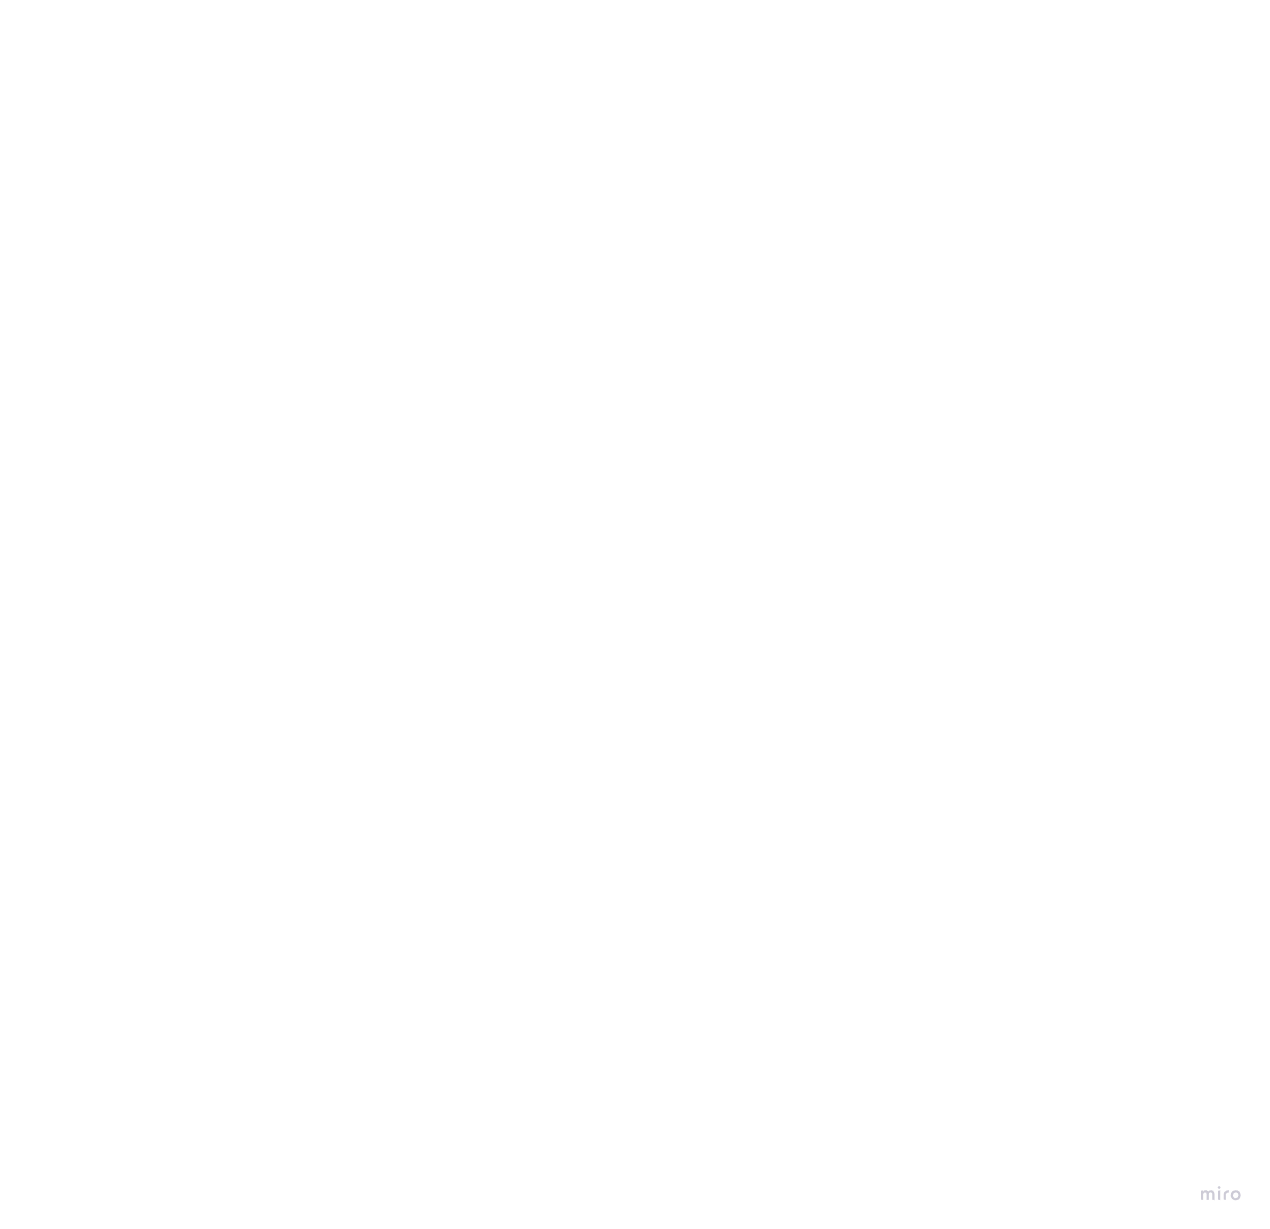

In [ ]:
class UserEncoder(nn.Module):
    def __init__(self):
        super(UserEncoder, self).__init__()
        self.userfc1 = nn.Linear(768, 512)
        self.userfc2 = nn.Linear(512, 512)
        self.userfc3 = nn.Linear(512, 512)
        self.userfc4 = nn.Linear(512, 256)

        self.moviefc1 = nn.Linear(768, 512)
        self.moviefc2 = nn.Linear(512, 512)
        self.moviefc3 = nn.Linear(512, 512)
        self.moviefc4 = nn.Linear(512, 256)

        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 768)

    def forward(self, user_embedding, movie_embedding):
        emb1 = self.userfc1(user_embedding)
        emb1 = F.relu(emb1)
        emb1 = self.userfc2(emb1)
        emb1 = F.relu(emb1)
        emb1 = self.userfc3(emb1)
        emb1 = F.relu(emb1)
        emb1 = self.userfc4(emb1)
        emb1 = F.relu(emb1)

        emb2 = self.moviefc1(movie_embedding)
        emb2 = F.relu(emb2)
        emb2 = self.moviefc2(emb2)
        emb2 = F.relu(emb2)
        emb2 = self.moviefc3(emb2)
        emb2 = F.relu(emb2)
        emb2 = self.moviefc4(emb2)
        emb2 = F.relu(emb2)
        
        emb = torch.cat([emb1, emb2], dim=0)

        emb = self.fc1(emb)
        emb = F.relu(emb)
        emb = self.fc2(emb)
        emb = F.relu(emb)
        emb = self.fc3(emb)
        emb = F.relu(emb)
        output = self.fc4(emb)
        
        return output

In [ ]:
def evaluate(grouped_users):
    all_losses = [] # Список средних MSE для каждого юзера
    
    for name, user in grouped_users:

        if user.shape[0] < 3: # Нам нужен как минимум первый посмотренный фильм, новый просмотренный и тестовый
            continue

        user_loss = [] # Список MSE для каждого фильма, который посмотрел юзер

        user_embedding = torch.tensor(user["embedding"].values[0])

        for index in range(1, user.shape[0]-1):

            movie_embedding = torch.tensor(user["embedding"].values[index]) # Только что просмотренный фильм
            comparing_embedding = torch.tensor(user["embedding"].values[index + 1]) # Еще "неизвестный" пользователю фильм
            target = torch.tensor(user["rating"].values[index + 1] / 5) # Оценка, которую "поставит" пользователь еще неизвестному фильму от 0 до 1

            with torch.no_grad():
                output = model(user_embedding, movie_embedding)
                loss = criterion(cos(output, comparing_embedding).to(torch.float32), target.to(torch.float32))
                user_loss.append(loss.item())
            

            user_embedding = output.detach() # Обновляем эмбеддинг пользователя после просмотра фильма

        all_losses.append(np.mean(user_loss)) 
    print(f"Средний MSE на тестовой выборке: {np.mean(all_losses)}")
    return np.mean(all_losses)

In [ ]:
model = UserEncoder()
criterion = nn.MSELoss()
cos = torch.nn.CosineSimilarity(dim = 0, eps=1e-6)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-7)


counter = 0
eval_losses = []
train_losses = []

for name, user in tqdm(grouped_train, leave=True):
    counter += 1

    if counter % 100 == 0:
        eval_losses.append(evaluate(grouped_test))

    user_embedding = torch.tensor(user["embedding"].values[0])
    for index in range(1, user.shape[0]-1):
        movie_embedding = torch.tensor(user["embedding"].values[index])
        comparing_embedding = torch.tensor(user["embedding"].values[index + 1])
        target = torch.tensor(user["rating"].values[index + 1] / 5)

        optimizer.zero_grad()

        output = model(user_embedding, movie_embedding)
        loss = criterion(cos(output, comparing_embedding).to(torch.float32), target.to(torch.float32))

        loss.backward()
        optimizer.step()

        user_embedding = output.detach()

        train_losses.append(loss.item())

  0%|          | 100/208380 [01:13<346:29:47,  5.99s/it]

Средний MSE на тестовой выборке: 0.23388503104879346


  0%|          | 199/208380 [02:04<12:13:46,  4.73it/s]

Средний MSE на тестовой выборке: 0.08232708904794658


  0%|          | 300/208380 [03:52<332:00:58,  5.74s/it]

Средний MSE на тестовой выборке: 0.054095998266997875


  0%|          | 401/208380 [05:07<239:02:50,  4.14s/it]

Средний MSE на тестовой выборке: 0.04880178452391141


  0%|          | 498/208380 [06:05<6:12:42,  9.30it/s]

Средний MSE на тестовой выборке: 0.049435302296381975


  0%|          | 599/208380 [07:01<22:51:55,  2.52it/s]

Средний MSE на тестовой выборке: 0.04659015158778691


  0%|          | 698/208380 [08:30<20:50:49,  2.77it/s]

Средний MSE на тестовой выборке: 0.04676296906299952


  0%|          | 800/208380 [10:15<235:04:49,  4.08s/it]

Средний MSE на тестовой выборке: 0.046701322423391374


  0%|          | 900/208380 [11:49<298:10:41,  5.17s/it]

Средний MSE на тестовой выборке: 0.048186464753739854


  0%|          | 998/208380 [12:35<10:22:25,  5.55it/s]

Средний MSE на тестовой выборке: 0.04950471734432066


  1%|          | 1100/208380 [14:09<286:39:28,  4.98s/it]

Средний MSE на тестовой выборке: 0.04632214435460052


  1%|          | 1109/208380 [14:13<44:19:36,  1.30it/s]


KeyboardInterrupt: ignored

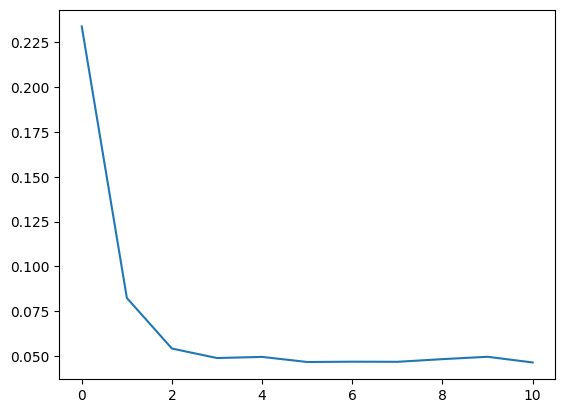

In [ ]:
plt.plot(eval_losses)